# Assignment 1
In this notebook, I have analyzed the Machine Learning and Data Science survey with 23860 samples and 50 questions.

This supervised machine learning classification problem has been done through logistic regression.
Steps involved are: 
1. Cleaning data and exploring the answers through EDA 
2. Checking the feature importance
3. Selection of features using Regression Technique
3. Training the model through Logistic Regression
4. Model and hyperparamter tuning

The dataset for this problem is from a csv file 'multiChoiceResponses.csv'

# Installing & Importing relevant libraries

In [101]:
!pip install mlxtend

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn import linear_model
from sklearn.linear_model import LassoLarsCV
from sklearn.datasets import make_regression
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from mlxtend.plotting import plot_learning_curves

# Read survey data from given file

In [103]:
Salaries = pd.read_csv("multipleChoiceResponses.csv", low_memory = False)

# Analyse various classes of yearly compensation, which is the target value for the problem
Salaries['Q9'].value_counts(dropna = False)

I do not wish to disclose my approximate yearly compensation    4756
0-10,000                                                        4398
NaN                                                             3674
10-20,000                                                       1937
20-30,000                                                       1395
30-40,000                                                       1119
40-50,000                                                        965
50-60,000                                                        919
100-125,000                                                      843
60-70,000                                                        729
70-80,000                                                        677
90-100,000                                                       566
125-150,000                                                      533
80-90,000                                                        506
150-200,000                       

In [104]:
# eliminate NaN values and 'I do not wish to disclose my approximate yearly compensation' rows from data
Salaries.dropna(subset=['Q9'],inplace=True)
Salaries = Salaries[Salaries['Q9']!= "I do not wish to disclose my approximate yearly compensation"]

In [105]:
Salaries.shape

(15430, 395)

We are left with 15430 rows, which needs to be re-indexed for easier reference

In [106]:
Salaries.loc[1:,'index'] = Salaries[1:].reset_index().index

In [107]:
Salaries.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,In what industry is your current employer/cont...,...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,NaN
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,Academics/Education,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0


Since question forms the first row, saving the survey answers in separate data-frame and questions in another data-frame

In [108]:
#separating Questions and answers in separate dataframe and the exporting to respective new csv file

df1 = Salaries.iloc[0,:]
df2 = Salaries.iloc[1:,:]
df2.to_csv("Kaggle_Salary_data_clean_new.csv")
df1.to_csv('Kaggle_Survey_Questions.csv', header = True)

In [109]:
#Further, two dataframes: answer dataframe- dfA and question dataframe dfQ, will be used for working

dfA = pd.read_csv("Kaggle_Salary_data_clean_new.csv", low_memory = False)
dfQ = pd.read_csv("Kaggle_Survey_Questions.csv", low_memory = False)

# Part 1 & 2: Cleaning, EDA (Visualization) & Encoding

Basic cleaning step involves the following:

    - Eliminating few rows if time taken to finish survey is too less (here time < 120 seconds)
    - Eliminating question if 2 or more questions are reduntant
    - Eliminating features (questions) if they logically do not impact the yearly compensation
    - Handling missing values

Each question is preprocessed using methods of sklearn:

    - Label Encoding
    - One Hot Encoding

In [110]:
#encoding functions

#label Encoding
def label_encode(col):
    le = LabelEncoder()
    encoded_col = le.fit_transform(col)
    classes = le.classes_
    return (encoded_col, classes)

#one hot encoding

def one_hot_encode(df, col):
    (le_col, classes) = label_encode(col) #gives the number of categories and label encoded column
    m = classes.size
    #print(m)
    n_features = le_col.shape[0]
    
    ohe =preprocessing.OneHotEncoder
    ohe_ = ohe(categories = [range(m)]*n_features)
    #print(ohe_)
    col_ohe = ohe_.fit_transform([le_col]) #gives a sparse matrix
    col_ohe_array = col_ohe.toarray().reshape(len((le_col)),-1).astype(int) # converting sparse matrix to array
    columns_name = []
    for i in classes:
        str= col.name + ' '+ i
        columns_name.append(str)
    #print(columns_name)
    col_ohe_encode = pd.DataFrame(col_ohe_array,columns=columns_name)
    col_ohe_encode = col_ohe_encode.reset_index(drop = True)
    df.reset_index(drop = True, inplace = True)
    #print(col_ohe_encode.shape)
    df= pd.concat([df, col_ohe_encode], sort = False, axis = 1)
    
    return df

#function for nan removal and label encoding

def remove_nan_label_encode(df, columns):
  #print(columns)
  for col in columns:
    df[col].fillna(0, inplace = True)
    df[col], _ = label_encode(df[col].astype(str))
  return df

In [111]:

#time based analysis
count = 0
a = []
m = 120 
for j,i in enumerate(dfA['Time from Start to Finish (seconds)']):
    i = int(i)
    if i <= 100:
        count += 1        
        a.append(dfA.loc[j, 'Q9'])
    
    
print("Instances with time less than ", m, ' seconds is', count)

t = np.array([[x,a.count(x)] for x in set(a)])
#print(t)


Instances with time less than  120  seconds is 137


Since most of the instances do not contribute to high salary and time taken to fill the survey of questions is very less (practically not possible)
Therefore, eliminating of such cases from data

In [112]:
row_index = dfA.loc[dfA['Time from Start to Finish (seconds)'] <= m].index

dfA = dfA.drop(row_index, axis = 0)
print(dfA.shape)

#re - indexing dataframe
dfA.loc[:,'index'] = dfA.reset_index()


(15144, 397)


In [113]:
#dopping 'Time from Start to Finish (seconds)' column - as it does not have any relation with yearly compensation
dfA.drop('Time from Start to Finish (seconds)', axis = 1, inplace = True)

Analyze the number of people in various categories of salaries (our target variable)

In [114]:
#Computing the average salary for each category e.g 0-10,000 saved as 5000
compensation = dfA['Q9'].str.replace(',', '').str.replace('500000\+', '500-500000').str.split('-')
salary_numerical = compensation.apply(lambda x: (int(x[0]) * 1000 + int(x[1]))/ 2) / 1000 


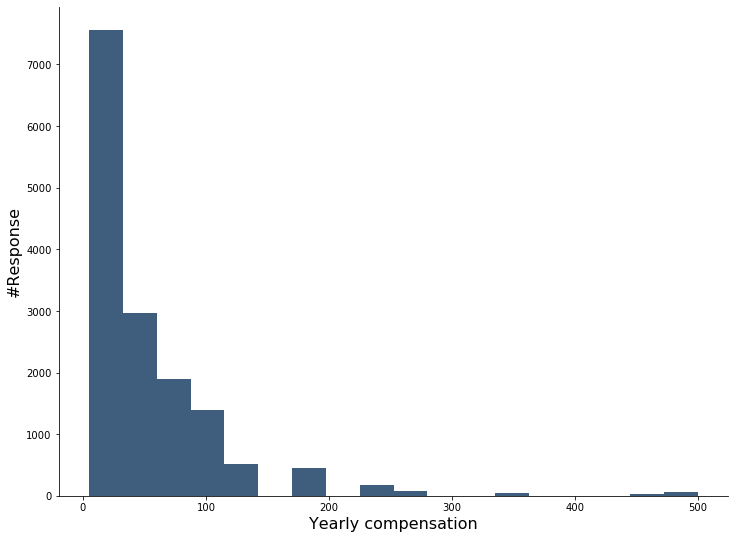

In [115]:
#plotting histogram

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.hist(salary_numerical,18, color="#3F5D7D")   #18 bins because 18 categories
plt.xlabel('Yearly compensation',fontsize = 16)
plt.ylabel('#Response', fontsize = 16)
plt.savefig("Salary vs responses", bbox_inches="tight")

From plot, it is evident that maximum responses had salary 0-10,000 USD, let's find out which category corresponded to this salary the most.
Q6 is about the current roles 

In [116]:
count = 0
for i,j in enumerate(dfA.Q9):
    if j == '0-10,000':
        count +=1

In [117]:
dfA_2 = dfA[dfA['Q9'] == '0-10,000']
a = dfA_2[dfA_2['Q6'] == 'Student']
a.shape
print('Percentage of students in 0-10,000 bracket', a.shape[0]/count*100)

Percentage of students in 0-10,000 bracket 44.57382394038193


First 8 questions involve personal information of a person

In [118]:
# Q1 (gender) --  'Prefer not to say' and 'Prefer to self-describe' categories and filling with most frequent 
#category (few values as compared to other categories)
#dfA['Q1'].value_counts(dropna = False)

In [119]:
dfA['Q1'].replace(to_replace = ['Prefer not to say', 'Prefer to self-describe'], value = dfA['Q1'].mode()[0], inplace = True)
#dfA['Q1'].value_counts(dropna = False)

In [120]:
# label encoding Q1
dfA['Q1'], _ = label_encode(dfA['Q1']) 

In [121]:
#Q2 filling missing values check
#dfA['Q2'].value_counts(dropna = False)

In [122]:
#no nan values performing on-hot encoding on the data and dropping 'Q2' column
dfA = one_hot_encode(dfA, dfA['Q2'])
dfA.drop('Q2', axis = 1, inplace = True)

In [123]:
dfA.shape

(15144, 407)

In [124]:
#checking the country data for missing values 
#dfA['Q3'].value_counts(dropna= False)

In [125]:
# encoding country data and dropping Q3
dfA = one_hot_encode(dfA, dfA['Q3'].astype(str))
dfA.drop('Q3', axis = 1, inplace = True)

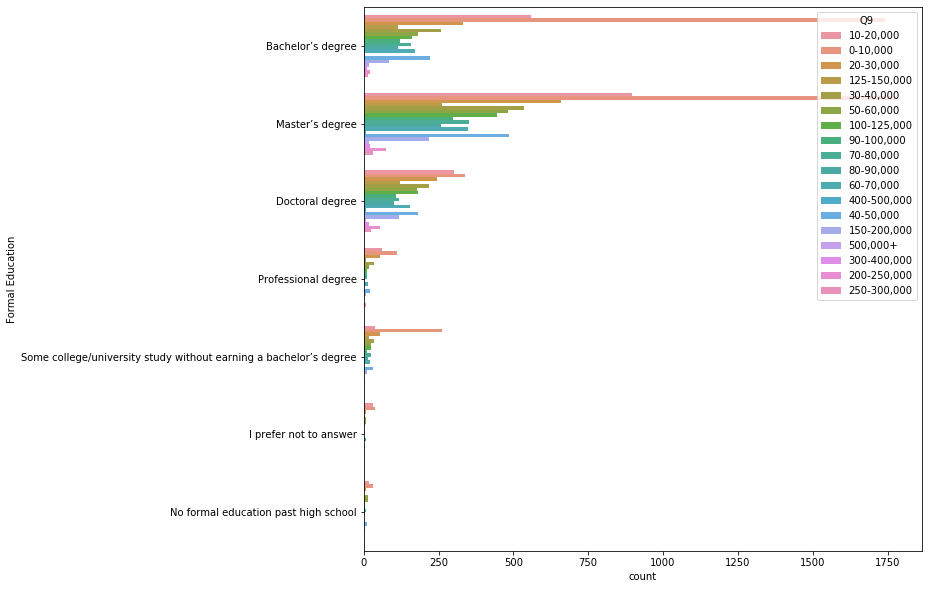

In [126]:
#plt.figure(12,9)
import seaborn as sb
dims = (10,10)
fig, ax = plt.subplots(figsize=dims)
figure = sb.countplot(ax = ax, y = dfA['Q4'], hue = dfA['Q9'], data = dfA)
plt.ylabel('Formal Education')
plt.xlabel('count')
plt.savefig("Formal Education", bbox_inches="tight")

From the plot it is evident that for very high salary, either Doctoral/Master's degree is required or formal education won't make much difference in salary (i.e very few high salaries in all other cases)

In [128]:
dfA['Salary_numerical'] = salary_numerical

0        15.0
1         5.0
2         5.0
3        15.0
4         5.0
         ... 
15139     5.0
15140     5.0
15141    15.0
15142    15.0
15143    55.0
Name: Salary_numerical, Length: 15144, dtype: float64

In [129]:
#Q4 filling missing values check
dfA['Q4'].value_counts(dropna = False)

Master’s degree                                                      7163
Bachelor’s degree                                                    4289
Doctoral degree                                                      2479
Some college/university study without earning a bachelor’s degree     574
Professional degree                                                   383
No formal education past high school                                  129
I prefer not to answer                                                127
Name: Q4, dtype: int64

In [130]:
# no NaN answers but 'I prefer not to answer', since very few such cases, encode Q4 using one hot and 
#drop the 'Q4 I prefer not to answer' columns
dfA = one_hot_encode(dfA, dfA['Q4'])
dfA.drop(['Q4','Q4 I prefer not to answer'], axis = 1, inplace = True)

Dropping undergraduate major because it is related to Q4, Since undergraduate degreee does not matter much for high salary, this feature can be eliminated

In [133]:
#dfA['Q5'].value_counts(dropna = False)
dfA.drop('Q5', axis = 1, inplace = True)

In [134]:
dfA = one_hot_encode(dfA, dfA['Q6'])
dfA.drop('Q6', axis = 1, inplace = True)


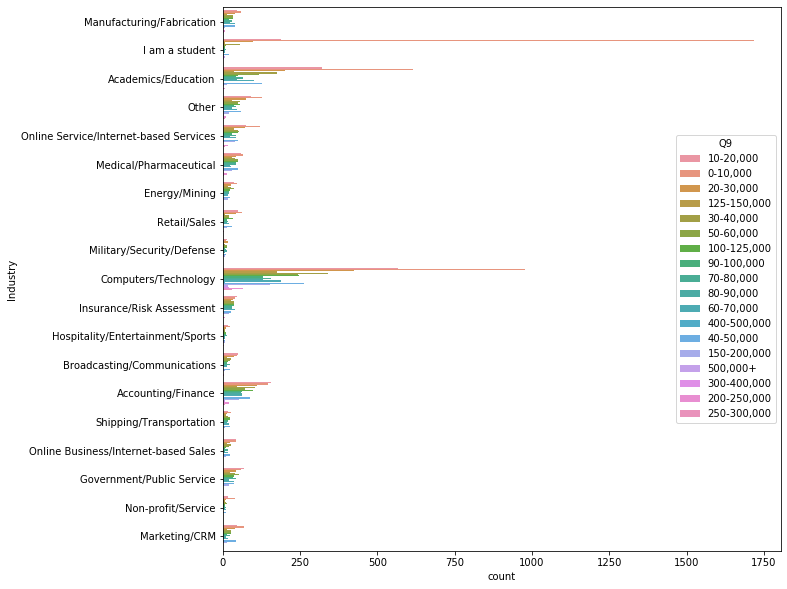

In [135]:
dims = (10,10)
fig, ax = plt.subplots(figsize=dims)
figure = sb.countplot(ax = ax, y = dfA['Q7'], hue = dfA['Q9'], data = dfA)
plt.ylabel('Industry')
plt.xlabel('count')
plt.savefig("Industry", bbox_inches="tight")

Almost all the industries have high salary categories, therefore it's better to take them all

In [136]:
dfA = one_hot_encode(dfA, dfA['Q7'])
dfA.drop('Q7', axis = 1, inplace = True)

In [137]:
dfA.shape

(15144, 506)

In [139]:
#Q8 very few nan values, therefore one hot encoding and then dropping nan value
dfA = one_hot_encode(dfA, dfA['Q8'].astype(str))
dfA.drop(['Q8', 'Q8 nan'], axis = 1, inplace = True)


In [140]:
#dropping columns with 'other text' option
dfA = dfA.drop(['Q1_OTHER_TEXT', 'Q6_OTHER_TEXT', 'Q7_OTHER_TEXT', 'Q11_OTHER_TEXT', 'Q12_OTHER_TEXT','Q13_OTHER_TEXT', 'Q14_OTHER_TEXT','Q15_OTHER_TEXT', 'Q16_OTHER_TEXT','Q17_OTHER_TEXT', 'Q18_OTHER_TEXT','Q19_OTHER_TEXT', 'Q20_OTHER_TEXT', 'Q21_OTHER_TEXT', 'Q22_OTHER_TEXT', 'Q27_OTHER_TEXT', 'Q28_OTHER_TEXT', 'Q29_OTHER_TEXT', 'Q30_OTHER_TEXT', 'Q31_OTHER_TEXT', 'Q33_OTHER_TEXT', 'Q34_OTHER_TEXT', 'Q35_OTHER_TEXT', 'Q36_OTHER_TEXT', 'Q37_OTHER_TEXT', 'Q38_OTHER_TEXT', 'Q42_OTHER_TEXT', 'Q49_OTHER_TEXT', 'Q50_OTHER_TEXT'], axis = 1   )


In [141]:
#Q10 one hot encoding but removing nan column as very few (249 cases in aprox. 12000)
dfA = one_hot_encode(dfA, dfA['Q10'].astype(str))
dfA.drop(['Q10', 'Q10 nan'], axis = 1, inplace = True)

In [142]:
# label encoding Q11
columns = dfQ.iloc[14:21,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

Q12,Q13, Q14 are about the platforms people use for coding. Since any language/platform can be used (if you know how to code), salary will not depend on these

In [143]:
#dropping Q12 
Q12_columns = dfQ.iloc[22:27,0].to_list()
dfA.drop(Q12_columns, axis = 1, inplace = True)

In [144]:
#dropping Q13
Q13_columns = dfQ.iloc[29:44,0].to_list()
dfA.drop(Q13_columns, axis =1, inplace = True)

In [145]:
#dropping Q14
Q14_columns = dfQ.iloc[45:56,0].to_list() 
dfA.drop(Q14_columns, axis =1, inplace = True)

In [146]:
# label encoding Q15
columns = dfQ.iloc[57:64,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

In [147]:
# label encoding Q16
columns = dfQ.iloc[65:83,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

In [148]:
#one hot encoding for Q17
dfA = one_hot_encode(dfA, dfA['Q17'].astype(str))
dfA.drop('Q17', axis = 1, inplace =True)

In [149]:
#one hot encoding for Q18
dfA = one_hot_encode(dfA, dfA['Q18'].astype(str))
dfA.drop('Q18', axis = 1, inplace =True)

In [150]:
# label encoding Q19
columns = dfQ.iloc[88:107,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

Q20, Q22 is again related to programming language - ML libraries will change with language. This won't define salary as any language should be fine

In [151]:
#drop Q20
Q20_columns = dfQ.iloc[108,0]
dfA.drop(Q20_columns, axis =1, inplace = True)

In [152]:
# label encoding Q21
columns = dfQ.iloc[110:123,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

In [153]:
# drop Q22
Q22_columns = dfQ.iloc[124,0]
dfA.drop(Q22_columns, axis =1, inplace = True)

In [154]:
#handling missing values in Q23 and using one hot encode
#dfA['Q23'].value_counts(dropna = False)
dfA['Q23'].fillna('nan', inplace = True)
for i,t in enumerate(dfA['Q23']):
    if t == 'nan':
        new_val = dfA.loc[i-1,'Q23']
        dfA.loc[i, 'Q23'] = new_val
dfA['Q23'].value_counts(dropna = False)
dfA = one_hot_encode(dfA, dfA['Q23'].astype(str))
dfA.drop('Q23', axis = 1, inplace = True)

In [155]:
#handling missing values in Q24 and using one hot encode
#dfA['Q24'].value_counts(dropna = False)
dfA['Q24'].fillna('nan', inplace = True)
for i,t in enumerate(dfA['Q24']):
    if t == 'nan':
        new_val = dfA.loc[i-1,'Q24']
        dfA.loc[i, 'Q24'] = new_val
dfA = one_hot_encode(dfA, dfA['Q24'].astype(str))
dfA.drop('Q24', axis = 1, inplace =True)

Q25 is redundant with experience column so dropping it

In [156]:
#dropping Q25
Q25_columns = dfQ.iloc[128,0]
dfA.drop(Q25_columns, axis =1, inplace = True)

In [157]:
#handling missing values in Q24 and using one hot encode
#dfA['Q26'].value_counts(dropna = False)
dfA['Q26'].fillna('nan', inplace = True)
for i,t in enumerate(dfA['Q26']):
    if t == 'nan':
        new_val = dfA.loc[i-1,'Q26']
        dfA.loc[i, 'Q26'] = new_val
dfA = one_hot_encode(dfA, dfA['Q26'].astype(str))
dfA.drop('Q26', axis = 1, inplace =True)

Working platform does not matter and does not decide the skillset, therefore dropping Q27,28,29

In [158]:
Q27_columns = dfQ.iloc[130:150,0]
#print(Q27_columns)
dfA.drop(Q27_columns, axis =1, inplace = True)
Q28_columns = dfQ.iloc[151:194,0]
#print(Q28_columns)
dfA.drop(Q28_columns, axis =1, inplace = True)
Q29_columns = dfQ.iloc[195:223,0]
#print(Q29_columns)
dfA.drop(Q29_columns, axis =1, inplace = True)

In [159]:
# label encoding Q30
columns = dfQ.iloc[224:249,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

In [160]:
# label encoding Q31
columns = dfQ.iloc[250:262,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

In [166]:
#dfA.Q32.value_counts(dropna = False)
#dfA.Q33_Part_1.value_counts(dropna = False)
#dfA.Q33_Part_10.value_counts(dropna = False)
#dfA.Q34_Part_1.value_counts(dropna = False)
#dfA.Q34_Part_4.value_counts(dropna = False)
#dfA.Q35_Part_3.value_counts(dropna = False)
#dfA.Q35_Part_5.value_counts(dropna = False)

Q32, 34,33,35 have huge amount of NaN values which might lead to bias. Therefore removing them

In [167]:
Q32_columns = dfQ.iloc[263,0]
#print(Q32_columns)
dfA.drop(Q32_columns, axis =1, inplace = True)
Q33_columns = dfQ.iloc[265:276,0]
#print(Q33_columns)
dfA.drop(Q33_columns, axis =1, inplace = True)
Q34_columns = dfQ.iloc[277:283,0]
#print(Q34_columns)
dfA.drop(Q34_columns, axis =1, inplace = True)
Q35_columns = dfQ.iloc[284:290,0]
#print(Q35_columns)
dfA.drop(Q35_columns, axis =1, inplace = True)

In [168]:
# label encoding Q36
columns = dfQ.iloc[291:304,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

In [169]:
Q37_columns = dfQ.iloc[305,0]
#print(Q37_columns)
dfA.drop(Q37_columns, axis =1, inplace = True)

In [170]:
# label encoding Q38
columns = dfQ.iloc[307:329,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

In [171]:
Q39_columns = dfQ.iloc[330:332,0]
#print(Q39_columns)
dfA.drop(Q39_columns, axis =1, inplace = True)

In [172]:
dfA['Q40'].value_counts(dropna = False)
#40% data is nan, therefore dropping this column
dfA.drop('Q40', axis = 1 , inplace = True)

Questions Q40, 43, 44, 45 have NaNs for majority sample. So dropping them

In [173]:
Q41_columns = dfQ.iloc[333:336,0]
#print(Q41_columns)
dfA.drop(Q41_columns, axis =1, inplace = True)

In [174]:
# label encoding Q42
columns = dfQ.iloc[336:340,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

In [175]:
Q43_columns = dfQ.iloc[342,0]
#print(Q43_columns)
dfA.drop(Q43_columns, axis =1, inplace = True)
Q44_columns = dfQ.iloc[343:349,0]
#print(Q44_columns)
dfA.drop(Q44_columns, axis =1, inplace = True)
Q45_columns = dfQ.iloc[349:355,0]
#print(Q45_columns)
dfA.drop(Q45_columns, axis =1, inplace = True)
Q46_columns = dfQ.iloc[355,0]
#print(Q46_columns)
dfA.drop(Q46_columns, axis =1, inplace = True)


In [176]:
# label encoding Q47
columns = dfQ.iloc[356:372,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

In [177]:
#dfA['Q48'].value_counts(dropna = False)
#more than 50% data is nan, therefore droppping column
dfA.drop('Q48', axis = 1 , inplace = True)


In [178]:
# label encoding Q49
columns = dfQ.iloc[373:385,0].to_list()
dfA = remove_nan_label_encode(dfA, columns)

In [179]:
Q50_columns = dfQ.iloc[386:394,0]
#print(Q50_columns)
dfA.drop(Q50_columns, axis =1, inplace = True)

In [180]:
dfA.head()

,Unnamed: 0,Q1,Q9,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,...,Q24 40+ years,Q24 5-10 years,Q24 < 1 year,Q24 I have never written code and I do not want to learn,Q24 I have never written code but I want to learn,Q26 Definitely not,Q26 Definitely yes,Q26 Maybe,Q26 Probably not,Q26 Probably yes
0,2,1,"10-20,000",0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
1,3,0,"0-10,000",1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,5,1,"0-10,000",0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,7,1,"10-20,000",0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,8,1,"0-10,000",0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [181]:
#dropping extra columns
dfA.drop(['Unnamed: 0','index', 'Salary_numerical'], axis = 1, inplace = True)

In [182]:
#dfA.to_csv('Kaggle_check.csv')

In [183]:
dfA.head()

,Q1,Q9,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q12_Part_5_TEXT,...,Q24 40+ years,Q24 5-10 years,Q24 < 1 year,Q24 I have never written code and I do not want to learn,Q24 I have never written code but I want to learn,Q26 Definitely not,Q26 Definitely yes,Q26 Maybe,Q26 Probably not,Q26 Probably yes
0,1,"10-20,000",0,0,0,0,0,1,0,-1,...,0,0,0,0,1,1,0,0,0,0
1,0,"0-10,000",1,0,0,0,0,0,0,-1,...,0,1,0,0,0,0,1,0,0,0
2,1,"0-10,000",0,0,0,0,0,0,1,-1,...,0,1,0,0,0,0,0,1,0,0
3,1,"10-20,000",0,0,0,0,0,1,0,-1,...,0,0,1,0,0,0,0,0,1,0
4,1,"0-10,000",0,1,0,0,0,0,0,-1,...,0,0,1,0,0,0,0,0,1,0


In [184]:
target_data = dfA['Q9']

In [186]:
Binary_data = dfA.drop('Q9', axis = 1)

Binary_data is the processed dataframe for further process

In [190]:
Binary_data.head()

,Q1,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q12_Part_5_TEXT,Q15_Part_1,...,Q24 40+ years,Q24 5-10 years,Q24 < 1 year,Q24 I have never written code and I do not want to learn,Q24 I have never written code but I want to learn,Q26 Definitely not,Q26 Definitely yes,Q26 Maybe,Q26 Probably not,Q26 Probably yes
0,1,0,0,0,0,0,1,0,-1,0,...,0,0,0,0,1,1,0,0,0,0
1,0,1,0,0,0,0,0,0,-1,0,...,0,1,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,1,-1,0,...,0,1,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,1,0,-1,1,...,0,0,1,0,0,0,0,0,1,0
4,1,0,1,0,0,0,0,0,-1,0,...,0,0,1,0,0,0,0,0,1,0


In [356]:
#Binary_data.to_csv('Kaggle_dummy.csv')

In [191]:
target_data_le, _ = label_encode(target_data)
#target_data_le = pd.DataFrame(target_data_le)
#target_data_le.iloc[:,0].value_counts(dropna = False)

In [192]:
#Q42_Part_5 has  string 'other' therefore removing it
Binary_data.drop('Q42_Part_5', axis = 1, inplace = True)

In [195]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

forest.fit(Binary_data, target_data)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(X.shape[1])print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:


0.01979067400439399

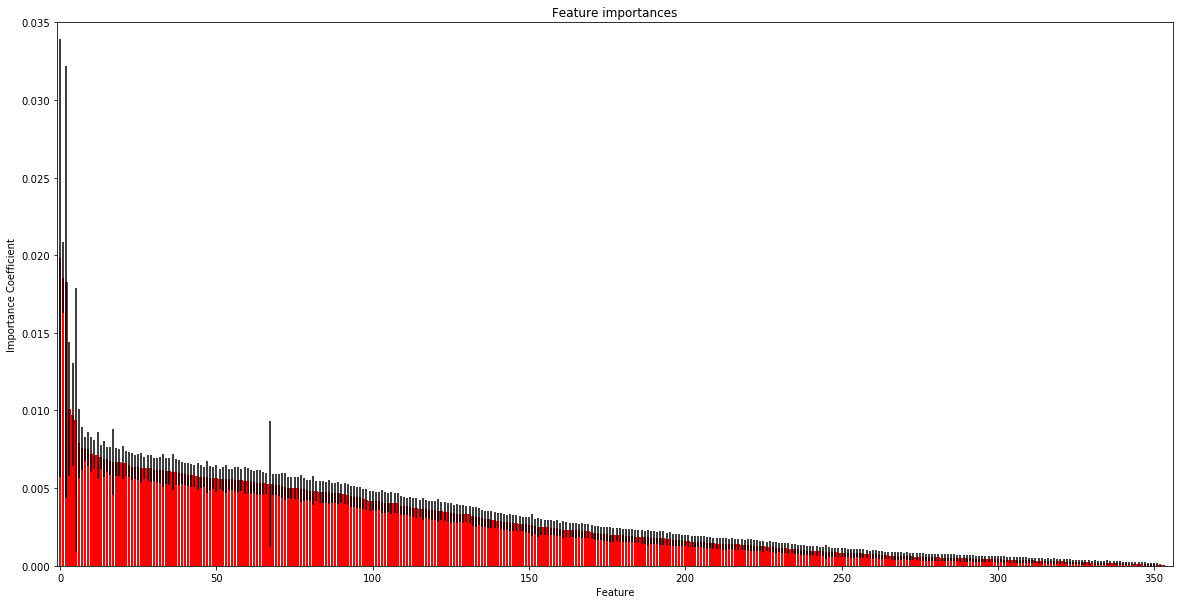

In [212]:
# Plot the feature importances of the forest
plt.figure(figsize = (20,10))
plt.title("Feature importances")
plt.bar(range(Binary_data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
#plt.xticks(range(Binary_data.shape[1]), indices)
plt.xlim([-1, Binary_data.shape[1]])
plt.ylim([-0,0.035])
plt.xlabel('Feature')
plt.ylabel('Importance Coefficient')
plt.show()

In [211]:
max_importance = importances.max()
index = np.where(max_importance)
print("Maximum importance coefficient is: ", max_importance, "at index", index[0])

Maximum importance coefficient is:  0.01979067400439399 at index [0]


The graph shows that of initial few features which involves personal data of samples is more important than the responses at the end of survey. The zoomed graph for few initial features shown below

In [217]:
type(std)

numpy.ndarray

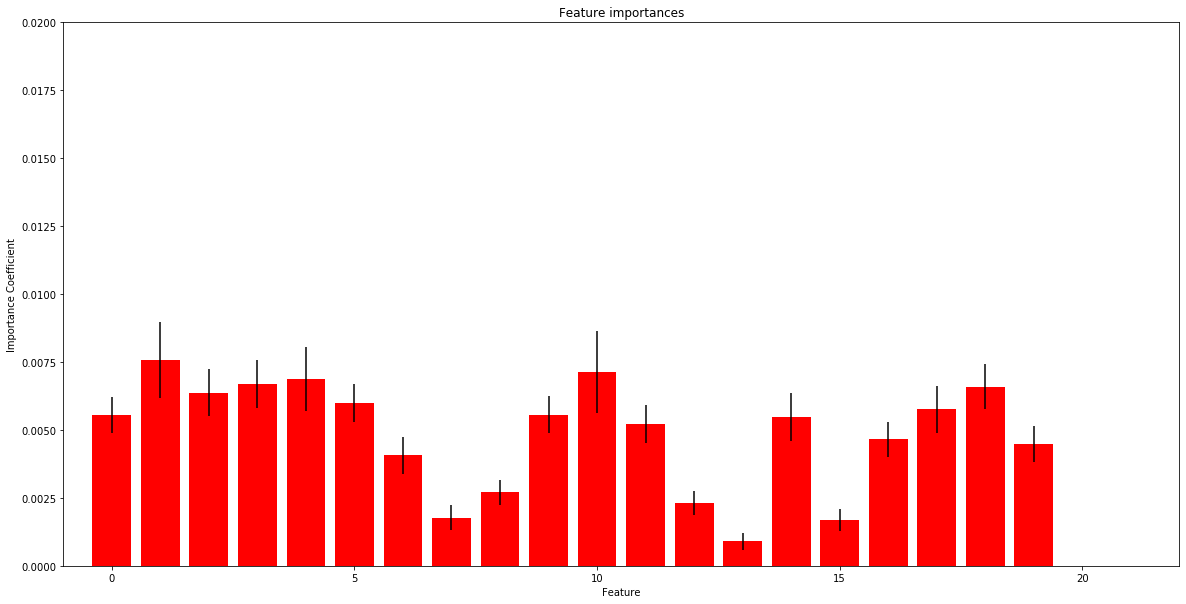

In [219]:
plt.figure(figsize = (20,10))
plt.title("Feature importances")
plt.bar(range(20), importances[0:20],
       color="r", yerr=std[0:20], align="center")
#plt.xticks(range(Binary_data.shape[1]), indices)
plt.xlim([-1, 22])
plt.ylim([-0,0.02])
plt.xlabel('Feature')
plt.ylabel('Importance Coefficient')
plt.show()

# Part 3 Feature Selection

While few features have been removed during cleaning, we still have a features corresponding to approx 25 questions which have been further encoded

How Feature Engineering is useful too?
Feature Engineering is constructing new variables to train ML model. Advantages of FE are:
1. Simple models can work well with help of feature engineering. Hence, flexibility on choosing a model
2. Lesser time to find the best model which is based on some metric (accuracy, precision, recall)
    Therefore, dataset with engineered features are less computationally expensive to work with

Feature Selection is converting data with too many features into a manageable data before training a model

Why Lasso regression?
Of all the regression models, LASSO seems to perform better when it comes to feature selection. LASSO penalizes the l1 norm of the weights, due to which coefficients of many features are forced to be zero. Thus, relevant features are allowed to have non zero weights. The degree of sparsity is controlled by the penality term.


In [220]:
#score validation for alpha value alpha = 0.05, 0.1, 1
#clf = linear_model.Lasso(alpha = 0.05)
#clf.fit(Binary_data, target_data_le)
#s = clf.score(Binary_data, target_data)

In [221]:
#Lasso regression with hyperparameter alpha = 0.05 (chosen based on best score)
clf = linear_model.Lasso(alpha = 0.05)
clf.fit(Binary_data, target_data_le)
coeff = clf.coef_
index = []
coeff_index = []

for i,j in enumerate(coeff):
    if j != 0:
        index.append(i)
        coeff_index.append(j)

# Considering features with non zero coefficients

In [222]:
Binary_data = Binary_data.iloc[:, index]

In [223]:
Binary_data.shape

(15144, 42)

With feature selection, the number of features have reduced to 42 and can be used for logistic regression

Splitting the data into training set and testing set

In [224]:
X_train, X_test, y_train, y_test = train_test_split(Binary_data, target_data, random_state=42, test_size=0.3)

# Logistic Regression Using Cross Validation

In [254]:
def Logistic_Reg(c, X_train, y_train):
    model = LogisticRegression(C = c,solver='saga', max_iter = 2500, multi_class='ovr' )
    scaler = StandardScaler()
    kfold = KFold(n_splits=10)
    kfold.get_n_splits(X_train)

    accuracy = np.zeros(10)
    np_idx = 0

    for train_idx, test_idx in kfold.split(X_train):
        X_train_cv, X_test_cv = X_train.values[train_idx], X_train.values[test_idx]
        y_train_cv, y_test_cv = y_train.values[train_idx], y_train.values[test_idx]
    
        X_train_cv = scaler.fit_transform(X_train_cv)
        X_test_cv = scaler.transform(X_test_cv)
    
        model.fit(X_train_cv, y_train_cv)
    
        predictions = model.predict(X_test_cv)
        acc = model.score(X_test_cv, y_test_cv)
           
        accuracy[np_idx] = acc*100
        np_idx += 1
        
        #print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

    print ("For model with C = ", c, "Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))
    return model, accuracy

In [255]:
import warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [256]:
m1, accuracy1 = Logistic_Reg(1,X_train, y_train)

For model with C =  1 Average Score: 33.849%(1.102%)


In [257]:
accuracy_test = []   #accuracy of training set and test se
accuracy_cv = []     #accuracy from cross validation

In [258]:
y_pred1 = m1.predict(X_test)
prob_1 = m1.predict_proba(X_test)

accuracy_test1 = m1.score(X_test, y_test)*100

accuracy_test.append(accuracy_test1)
accuracy_cv.append(accuracy1.mean())


In [259]:
y_pred_train1 = m1.predict(X_train)
prob_train1 = m1.predict_proba(X_train)

In [260]:
from sklearn.metrics import log_loss
train_logloss_1 = log_loss(y_train, prob_train1)
test_logloss_1 = log_loss(y_test, prob_1)

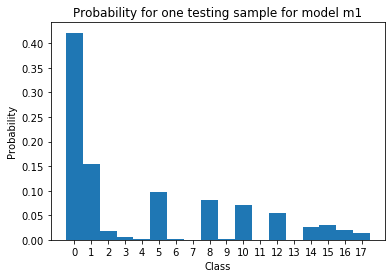

In [261]:
#sb.distplot(prob_1, hist = True, bins = 18, color = 'darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})
plt.bar(range(18),prob_1[1,:], width = 1)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Probability for one testing sample for model m1')
plt.xticks(range(18))
plt.show()

Model with hyperparameter c = 0.1

In [262]:
m2, accuracy2 = Logistic_Reg(0.1, X_train, y_train)

For model with C =  0.1 Average Score: 33.84%(1.035%)


In [263]:
y_pred2 = m2.predict(X_test)
prob_2 = m2.predict_proba(X_test)

accuracy_test2 = m2.score(X_test, y_test)*100

accuracy_test.append(accuracy_test2)
accuracy_cv.append(accuracy2.mean())

In [264]:
y_pred_train2 = m2.predict(X_train)
prob_train2 = m2.predict_proba(X_train)

In [265]:
train_logloss_2 = log_loss(y_train, prob_train2)
test_logloss_2 = log_loss(y_test, prob_2)

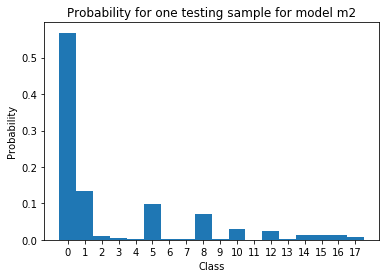

In [266]:
#sb.distplot(prob_1, hist = True, bins = 18, color = 'darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})
plt.bar(range(18),prob_2[28,:], width = 1)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Probability for one testing sample for model m2')
plt.xticks(range(18))
plt.show()

Model with hyperparameter c = 0.001

In [267]:
m3, accuracy3 = Logistic_Reg(0.001, X_train, y_train)

For model with C =  0.001 Average Score: 32.038%(1.666%)


In [268]:
y_pred3 = m3.predict(X_test)
prob_3 = m3.predict_proba(X_test)

accuracy_test3 = m3.score(X_test, y_test)*100

accuracy_test.append(accuracy_test3)
accuracy_cv.append(accuracy3.mean())

In [269]:
y_pred_train3 = m3.predict(X_train)
prob_train3 = m3.predict_proba(X_train)

In [270]:
train_logloss_3 = log_loss(y_train, prob_train3)
test_logloss_3 = log_loss(y_test, prob_3)

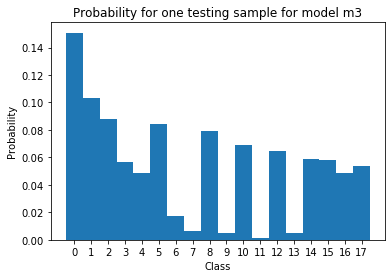

In [271]:
#sb.distplot(prob_1, hist = True, bins = 18, color = 'darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})
plt.bar(range(18),prob_3[78,:], width = 1)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Probability for one testing sample for model m3')
plt.xticks(range(18))
plt.show()

Model with hyperparameter c = 0.00001

In [272]:
m4, accuracy4 = Logistic_Reg(0.00001, X_train, y_train)

For model with C =  1e-05 Average Score: 28.179%(1.396%)


In [273]:
y_pred4 = m4.predict(X_test)
prob_4 = m4.predict_proba(X_test)

accuracy_test4 = m4.score(X_test, y_test)*100

accuracy_test.append(accuracy_test4)
accuracy_cv.append(accuracy4.mean())

In [274]:
y_pred_train4 = m4.predict(X_train)
prob_train4 = m4.predict_proba(X_train)

In [275]:
train_logloss_4 = log_loss(y_train, prob_train4)
test_logloss_4 = log_loss(y_test, prob_4)

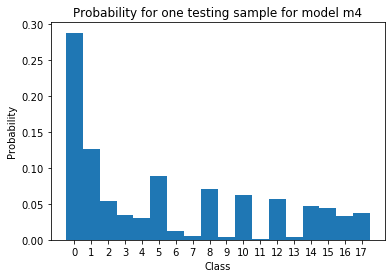

In [276]:
#sb.distplot(prob_1, hist = True, bins = 18, color = 'darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})
plt.bar(range(18),prob_4[101,:], width = 1)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Probability for one testing sample for model m4')
plt.xticks(range(18))
plt.show()

Model with hyperparameter c = 10

In [277]:
m5, accuracy5 = Logistic_Reg(10, X_train, y_train)

For model with C =  10 Average Score: 33.821%(1.103%)


In [278]:
y_pred5 = m5.predict(X_test)
prob_5 = m5.predict_proba(X_test)

accuracy_test5 = m5.score(X_test, y_test)*100

accuracy_test.append(accuracy_test5)
accuracy_cv.append(accuracy5.mean())

In [279]:
y_pred_train5 = m5.predict(X_train)
prob_train5 = m5.predict_proba(X_train)

In [280]:
train_logloss_5 = log_loss(y_train, prob_train5)
test_logloss_5 = log_loss(y_test, prob_5)

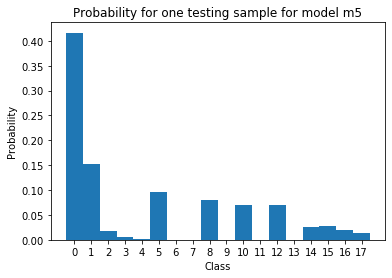

In [281]:
#sb.distplot(prob_1, hist = True, bins = 18, color = 'darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})
plt.bar(range(18),prob_5[1,:], width = 1)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Probability for one testing sample for model m5')
plt.xticks(range(18))
plt.show()

Model with hyperparameter c = 100

In [282]:
c_list = [1,0.1, 0.001, 0.00001,10]
training_logloss = [train_logloss_1, train_logloss_2, train_logloss_3, train_logloss_4, train_logloss_5]
testing_logloss = [test_logloss_1, test_logloss_2, test_logloss_3, test_logloss_4, test_logloss_5]
accuracy_cv = [accuracy1.mean(), accuracy2.mean(), accuracy3.mean(), accuracy4.mean(), accuracy5.mean()]
accuracy_test = [accuracy_test1, accuracy_test2, accuracy_test3, accuracy_test4, accuracy_test5]
variance_cv = [(accuracy1.std())**2, (accuracy2.std())**2, (accuracy3.std())**2, (accuracy4.std())**2, (accuracy5.std())**2]

summary_array = np.column_stack((accuracy_cv, variance_cv, accuracy_test,training_logloss, testing_logloss))

In [283]:
summary = pd.DataFrame(data = summary_array, index = c_list, 
                       columns = ['accuracy_cv', 'variance_cv', 'accuracy_test','training_logloss','testing_logloss'])

In [288]:
print("Summary of the model for different c is: ")
display(summary)

Summary of the model for different c is: 


,accuracy_cv,variance_cv,accuracy_test,training_logloss,testing_logloss
1.00000,33.849057,1.215379,28.521127,2.371209,2.489926
0.10000,33.839623,1.071645,28.565141,2.350671,2.466560
0.00100,32.037736,2.777145,28.411092,2.323693,2.366846
0.00001,28.179245,1.949181,28.763204,2.383351,2.372392
10.00000,33.820755,1.216180,28.455106,2.386409,2.506454


From the tables and probability graphs above, following are the inferences:
1. Models are not overfit
    -Variance of accuracies of different folds is very low
    -Comparing mean accuracy of cross validation (accuracy_cv) and test set accuracy, they are almost same. 
2. From probability of random samples in each model, it seems that model is biased towards low salary class (0-10,000 k).
    However, it needs to be checked through various other methods

# Error vs model complexity curve
For each model, traning error and testing error is computed using log loss function and plotted against (log(1/c))

Model complexity axis: m5 (c = 10), m1(c = 1), m2 (c = 0.1), m3(c = 0.001) and m4 (c = 0.00001) respectively


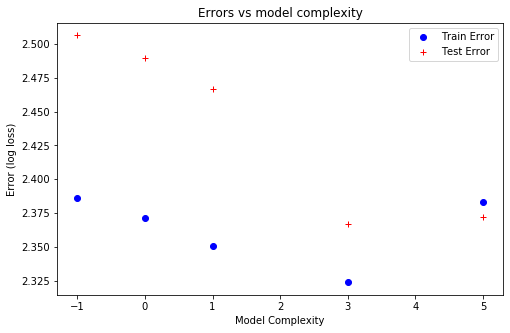

<Figure size 432x288 with 0 Axes>

In [342]:
import math
u = [1,10,1000,100000,0.1] #1/c_list
a = [math.log(y,10) for y in u]
print("Model complexity axis: m5 (c = 10), m1(c = 1), m2 (c = 0.1), m3(c = 0.001) and m4 (c = 0.00001) respectively")
plt.figure(figsize = (8,5))
plt.plot(a, training_logloss, 'bo', label = 'Train Error')
plt.plot(a, testing_logloss, 'r+', label = 'Test Error')
plt.xlabel('Model Complexity')
plt.ylabel('Error (log loss)')
plt.title('Errors vs model complexity')
plt.legend()
plt.show()
plt.savefig("Error vs model complexity", bbox_inches = 'tight')

From the above curve, models m5 and m1 seems to have high bias - therefore can be underfit
m4 has high variance among all (could be classified as overfit)
m3 corresponding to c = 0.001 seems to be the optimum case

# Part - 6 Optimal Model 

In [310]:
from sklearn.model_selection import GridSearchCV

In [311]:
parameters = {'solver':['saga', 'newton-cg', 'lbfgs', 'sag'] }
m_optimal = GridSearchCV(m3, parameters, cv = 5)

In [312]:
m_optimal.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=0.001, class_weight=None,
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=2500, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['saga', 'newton-cg', 'lbfgs', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [313]:
display(m_optimal.cv_results_)

{'mean_fit_time': array([217.15127006,  12.44493237,   7.92993035, 159.21478629]),
 'std_fit_time': array([3.44305172, 1.63238609, 2.16892662, 1.24938576]),
 'mean_score_time': array([0.01178679, 0.01334491, 0.01247759, 0.02466745]),
 'std_score_time': array([0.00803815, 0.01795231, 0.01845867, 0.02804869]),
 'param_solver': masked_array(data=['saga', 'newton-cg', 'lbfgs', 'sag'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'solver': 'saga'},
  {'solver': 'newton-cg'},
  {'solver': 'lbfgs'},
  {'solver': 'sag'}],
 'split0_test_score': array([0.28242481, 0.28242481, 0.28242481, 0.28242481]),
 'split1_test_score': array([0.2826905 , 0.28363123, 0.28363123, 0.28363123]),
 'split2_test_score': array([0.28490566, 0.28490566, 0.28490566, 0.28490566]),
 'split3_test_score': array([0.2833491 , 0.28382214, 0.28382214, 0.28382214]),
 'split4_test_score': array([0.28361742, 0.28409091, 0.28409091, 0.28409091]),
 'mean_test_scor

In [314]:
m_optimal.best_params_

{'solver': 'newton-cg'}

In [315]:
m_optimal.scorer_

<function sklearn.metrics.scorer._passthrough_scorer(estimator, *args, **kwargs)>

Thus the optimal solver for m3 (c = 0.001) is newton_cg/sag/lbfgs - All of them are ranked 1

Now, using c = 0.001 and newton_cg for optimal model performance

In [317]:
m_optimal_NCG, accuracy_NCG = Logistic_Reg(0.001, X_train, y_train)

For model with C =  0.001 Average Score: 32.038%(1.666%)


In [318]:
y_pred_NCG = m_optimal_NCG.predict(X_test)
prob_NCG = m_optimal_NCG.predict_proba(X_test)

accuracy_testNCG = m_optimal_NCG.score(X_test, y_test)*100


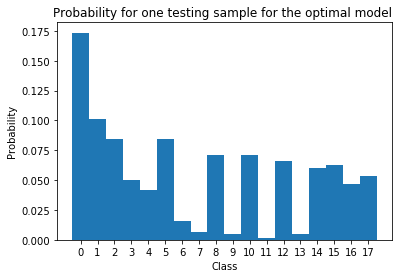

<Figure size 432x288 with 0 Axes>

In [326]:
plt.bar(range(18),prob_NCG[98,:], width = 1)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Probability for one testing sample for the optimal model ')
plt.xticks(range(18))
plt.show()
plt.savefig("Probability for one testing sample for the optimal model", bbox_inches="tight")

In [331]:
print("Accuracy on testing set for optimal model: ", accuracy_testNCG, '%')

Accuracy on testing set for optimal model:  28.411091549295776 %


In [333]:
y_pred_trainNCG = m_optimal_NCG.predict(X_train)
prob_trainNCG = m_optimal_NCG.predict_proba(X_train)

In [334]:
train_logloss_NCG = log_loss(y_train, prob_trainNCG)
test_logloss_NCG = log_loss(y_test, prob_NCG)

In [335]:
print('Testing Error: ', test_logloss_NCG)
print('Training Error: ', train_logloss_NCG)

Testing Error:  2.3668574798928743
Training Error:  2.323700949572794


In [339]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

Mean accuracy of cross_validation score is 28.37% and accuracy on training set is 28.41. Therefore, the model is not overfit.

The accuracy is not good, therefore it is not a good model. It may be due to dropping of relevant features which could have affected accuracy.
Accuracy could be further increased by using better feature selection and performing feature engineering.

While we can say the model is not overfit through variance. Variance refers to how much the model is dependent on the training data.
High Bias and low variance means the model is underfit.